<a href="https://colab.research.google.com/github/faizanhemotra/CE888/blob/main/Project/Irony_XL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data

In [ ]:
import numpy as np
import random
import re
import requests

In [ ]:
def shape_data(feature, label):
    '''Returns number of rows for feature and label'''
    return len(feature.splitlines()), len(label.splitlines())

In [ ]:
irony_train_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/train_text.txt'
irony_train = requests.get(irony_train_url)
irony_train_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/train_labels.txt'
irony_train_labels = requests.get(irony_train_labels_url)
print('Irony Training, Label')
shape_data(irony_train.text, irony_train_labels.text)

Irony Training, Label


(2862, 2862)

In [ ]:
irony_val_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/val_text.txt'
irony_val = requests.get(irony_val_url)
irony_val_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/val_labels.txt'
irony_val_labels = requests.get(irony_val_labels_url)
print('Irony Validation, Label')
shape_data(irony_val.text, irony_val_labels.text)

Irony Validation, Label


(955, 955)

In [ ]:
irony_test_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/test_text.txt'
irony_test = requests.get(irony_test_url)
irony_test_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/test_labels.txt'
irony_test_labels = requests.get(irony_test_labels_url)
print('Irony Test, Label')
shape_data(irony_test.text, irony_test_labels.text)

Irony Test, Label


(784, 784)

##Labels

In [ ]:
irony_train_distr = list()
for label in irony_train_labels.text.splitlines():
    irony_train_distr.append(int(label))

irony_val_distr = list()
for label in irony_val_labels.text.splitlines():
    irony_val_distr.append(int(label))

irony_test_distr = list()
for label in irony_test_labels.text.splitlines():
    irony_test_distr.append(int(label))

In [ ]:
labels = list(set(irony_train_distr))
print(labels)

[0, 1]


In [ ]:
def linkremover(text):
    '''Removes t.co and instagram.com links from the data'''
    tco = r'https?://t.co/[\w]{10}'
    insta = r'https?://(www.)?instagram.com/p/[-\w]{11}/?'
    if (re.findall(tco + '|' + insta, text) != []):
        final = re.sub(tco + '|' + insta, '', text)
        return final
    else:
        print('No links')
    return text

In [ ]:
irony_tr = linkremover(irony_train.text)
irony_v = linkremover(irony_val.text)
irony_te = linkremover(irony_test.text)

In [ ]:
import os
import torch
hftransformers = os.path.exists('/content/transformers')
if hftransformers:
  print('transformers already downloaded ')
else:
  !git clone https://github.com/huggingface/transformers.git

transformers already downloaded 


In [ ]:
cd transformers

/content/transformers


In [ ]:
if hftransformers:
  print('transformers already downloaded ')
else:
  !pip3 install --upgrade .

transformers already downloaded 


In [ ]:
import importlib
emoji = importlib.util.find_spec("emoji")
found = emoji is not None
if found:
  print('emoji package already exists')
else:
  !pip3 install emoji

emoji package already exists


## Tokenizing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased', use_fast=False)

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
train_encodings = tokenizer(irony_tr.splitlines(), truncation=True, padding=True)
valid_encodings = tokenizer(irony_v.splitlines(), truncation=True, padding=True)
test_encodings = tokenizer(irony_te.splitlines(), truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
class Irony(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = Irony(train_encodings, irony_train_distr)
valid_dataset = Irony(valid_encodings, irony_val_distr)
test_dataset = Irony(test_encodings, irony_test_distr)

##Training

In [ ]:
from sklearn.metrics import f1_score
from transformers import XLNetForSequenceClassification, Trainer, TrainingArguments

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    return {
        'f1': f1
    }

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', cache_dir='cache/', num_labels=len(labels))
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total # of training epochs
    per_device_train_batch_size=12,  # batch size per device during training
    per_device_eval_batch_size=12,   # batch size for evaluation
    evaluation_strategy='epoch',
    disable_tqdm=False,
    load_best_model_at_end=True,
    save_strategy='epoch',
    save_total_limit=7,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=8,
    logging_dir='./logs',            # directory for storing logs
    dataloader_num_workers=2,
    run_name='xlnet-classification'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
if device == 'cuda':
  !nvidia-smi

Fri Apr 16 15:42:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    29W /  70W |   1548MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.694100,0.665285,0.563524
2,0.639000,0.614836,0.644623
3,0.579100,0.587638,0.680334
4,0.287500,0.927578,0.658476
5,0.096000,1.350008,0.694987


TrainOutput(global_step=1195, training_loss=0.4896876297984662, metrics={'train_runtime': 1793.5204, 'train_samples_per_second': 0.666, 'total_flos': 3313779004940040.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 2335059968, 'init_mem_gpu_alloc_delta': 469504512, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 481218560, 'train_mem_gpu_alloc_delta': 1899255296, 'train_mem_cpu_peaked_delta': 16384, 'train_mem_gpu_peaked_delta': 5560568320})

In [ ]:
torch.save(model.state_dict(), 'model_xlnet_irony.pth')

## Evaluations

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    conf_mat: confusion matrix
    classes: names of classes to be annotated
    normalize: [True/False] whether to normalise by column
    """
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Validation Dataset

In [ ]:
val_pred = trainer.predict(valid_dataset)
val_pred.metrics

{'test_f1': 0.6803343737253719,
 'test_loss': 0.5876384377479553,
 'test_mem_cpu_alloc_delta': 413696,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_gpu_peaked_delta': 68601856,
 'test_runtime': 5.3908,
 'test_samples_per_second': 177.154}

In [ ]:
validation_pred = []
for i in range(len(val_pred.predictions)):
  validation_pred.append(np.argmax(val_pred.predictions[i]))

Normalized confusion matrix


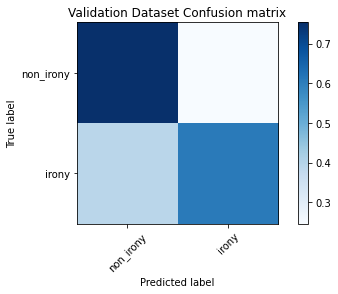

In [ ]:
cnf_matrix = confusion_matrix(irony_val_distr, validation_pred)
plot_confusion_matrix(cnf_matrix, classes=['non_irony', 'irony'], normalize=True,
                      title='Validation Dataset Confusion matrix')

In [ ]:
print(classification_report(irony_val_distr, validation_pred, digits=5))

              precision    recall  f1-score   support

           0    0.67748   0.75351   0.71347       499
           1    0.69250   0.60746   0.64720       456

    accuracy                        0.68377       955
   macro avg    0.68499   0.68048   0.68033       955
weighted avg    0.68465   0.68377   0.68183       955



### Test Dataset

In [ ]:
te_pred = trainer.predict(test_dataset)
te_pred.metrics

{'test_f1': 0.6703476663642198,
 'test_loss': 0.5769993662834167,
 'test_mem_cpu_alloc_delta': 155648,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_gpu_peaked_delta': 114506240,
 'test_runtime': 5.6666,
 'test_samples_per_second': 138.356}

In [ ]:
test_pred = []
for i in range(len(te_pred.predictions)):
  test_pred.append(np.argmax(te_pred.predictions[i]))

Normalized confusion matrix


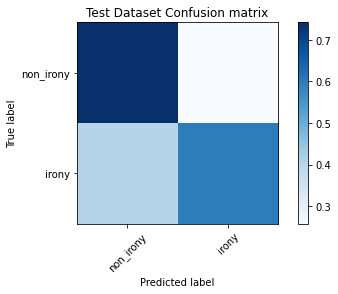

In [ ]:
cnf_matrix = confusion_matrix(irony_test_distr, test_pred)
plot_confusion_matrix(cnf_matrix, classes=['non_irony', 'irony'], normalize=True,
                      title='Test Dataset Confusion matrix')

In [ ]:
print(classification_report(irony_test_distr, test_pred, digits=5))

              precision    recall  f1-score   support

           0    0.73739   0.74207   0.73973       473
           1    0.60390   0.59807   0.60097       311

    accuracy                        0.68495       784
   macro avg    0.67065   0.67007   0.67035       784
weighted avg    0.68444   0.68495   0.68468       784



## Saving to Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r ./model_emotion.pth /content/drive/MyDrive